<a href="https://colab.research.google.com/github/Karenw1004/TreasureHunt/blob/main/notebooks/TreasureHunt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from google.colab import output
from tqdm import tqdm
import random
import seaborn
import matplotlib.pyplot as plt

# Initialize the map without starting position 

In [2]:
#        0    1   2   3   4   5   6   7   8   9   10
maze = [["W","W","W","W","W","E","W","W","W","W","W"],
        ["W","R","R","R","R","R","R","R","R","R","W"],
        ["W","R","W","W","W","W","W","R","W","R","W"],
        ["W","R","R","R","R","R","R","R","W","R","W"],
        ["W","W","W","R","W","W","W","R","W","W","W"],
        ["R","R","R","R","R","R","R","R","R","R","R"],
        ["W","W","W","W","W","R","W","W","W","W","W"],
        ["W","R","R","R","R","R","R","R","R","R","W"],
        ["W","W","W","R","W","W","W","R","W","W","W"],
        ["R","R","R","R","R","R","R","R","R","R","R"],
        ["W","W","W","W","W","W","W","W","W","W","W"]]

In [3]:
maze_row = len(maze)
maze_col = len(maze[0])

Make a mapping dictionary with chars as key and tuple key

> "C": (emoji-unicode, rewards)

emoji-unicode is from <br/>
https://unicode.org/emoji/charts/emoji-list.html

In [4]:
mapping = {
    # Road
    "R": ("\N{white large square}", -1),
    # END
    "E": ("\N{party popper}", 1000) ,
    # Wall
    "W": ("\N{brick}", -100),
    # Human
    "H": ("\N{girl}", None),
    # Gold
    "G": ("\N{money bag}", 30),
    # Thief
    "T": ("\N{smiling face with horns}", -30),
    # Bomb
    "B" : ("\N{bomb}", -1000) 
}

In [5]:
def print_maze(human_pos):
  for i in range(len(maze)):
    for j in range(len(maze[0])):
      if ((i == human_pos[0]) and (j == human_pos[1])):
        val = "H"
      else:
        val = maze[i][j]
      emoji = mapping[val][0]
      print(emoji,end=" " )
    print("\n")


In [6]:
print_maze((maze_row+1,maze_col+1))

🧱 🧱 🧱 🧱 🧱 🎉 🧱 🧱 🧱 🧱 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 

🧱 ⬜ 🧱 🧱 🧱 🧱 🧱 ⬜ 🧱 ⬜ 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 ⬜ 🧱 

🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 

⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 

🧱 🧱 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 🧱 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 

🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 

⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 

🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 



maze looks good

# Q learning
## Q table with n cols, m rows, number_of_actions
0. Up
1. Right
2. Down
3. Left

In [7]:
q_table = np.zeros((maze_row, maze_col,  4))

## Next action should be the max reward

In [8]:
def get_next_action(row, col, epilson):
  if np.random.random() < epilson:
    return np.argmax(q_table[row,col])
  else:
    return np.random.randint(4)

## Movement of the suggested action

In [9]:
def get_next_step(row, col,step_index):
  up_right_down_left = [(row-1,col),(row,col+1),(row+1,col),(row,col-1)]
  x, y = up_right_down_left[step_index]
  if 0 <= x < maze_row and 0 <= y < maze_col:
    return up_right_down_left[step_index]
  else:
    return (row, col) # No change

## Terminal state is the end of an episode.
- When you crash the wall, GAME OVER
- When you reach the end, DONE


In [10]:
terminal_state = ["W","E"]
def is_terminal_state(row, col):
  return maze[row][col] in terminal_state

In [11]:
is_terminal_state(0,0)

True

## Get the starting position (randomly) that should not be the terminal state

In [12]:
def get_random_starting_pos():
  while True:
    row = np.random.randint(maze_row)
    col = np.random.randint(maze_col)
    if not is_terminal_state(row,col):
      return (row,col)

In [13]:
get_random_starting_pos()

(2, 9)

## Training

In [14]:
epilson = 0.9
discount_factor = 0.9
learning_rate = 0.9
epochs = 1000

$
\underbrace{\text{New}Q(s,a)}_{\scriptstyle\text{New Q-Value}} =
\underbrace{Q(s,a)}_{\scriptstyle\text{Old Q-Value}}+
\mkern-34mu\underset{\text{Learning Rate}}{\underset{\Bigl|}{\alpha}}\mkern-30mu[\underbrace{R(s,a)}_{\scriptstyle\text{Reward}}+
\mkern-30mu\underset{\text{Discount rate}}{\underset{\Biggl|}{\gamma}}\mkern-75mu\overbrace{\max Q'(s',a')}^{\scriptstyle\substack{\text{Maximum predicted reward, given} \\ \text{new state and all possible actions}}}\mkern-45mu-Q(s,a)]
$

In [15]:
def train():
  for _ in tqdm(range(epochs)):
    row, col = get_random_starting_pos()

    while not is_terminal_state(row,col):
      action_index = get_next_action(row,col, epilson)

      old_row, old_col = row , col
      row , col = get_next_step(row,col,action_index)

      reward = mapping[ maze[row][col] ][1]
      old_q_val = q_table[old_row, old_col, action_index]
      temporal_diff = reward + (discount_factor * np.max(q_table[row, col])) - old_q_val
      
      new_q_val = old_q_val + (learning_rate * temporal_diff)
      q_table[old_row, old_col, action_index] = new_q_val

  print("\nTraining done!")

In [16]:
train()

100%|██████████| 1000/1000 [00:00<00:00, 3688.62it/s]


Training done!


In [17]:
def get_shortest_path(row, col):
  if is_terminal_state(row, col):
    return []
  else: 
    cur_row , cur_col = row, col
    shortest_path = []
    shortest_path.append((cur_row, cur_col))
    while not is_terminal_state(cur_row, cur_col):
      action_index = get_next_action(cur_row, cur_col, 1.)
      cur_row, cur_col = get_next_step(cur_row, cur_col, action_index)
      shortest_path.append((cur_row, cur_col))
    return shortest_path

In [18]:
def print_movement(path):
  for i in range(len(path)):
    print(f"Step {i}")
    coords = path[i]
    print_maze(coords)

In [19]:
human_pos = (9,0)
path = get_shortest_path(human_pos[0], human_pos[1])
print_movement(path)


Step 0
🧱 🧱 🧱 🧱 🧱 🎉 🧱 🧱 🧱 🧱 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 

🧱 ⬜ 🧱 🧱 🧱 🧱 🧱 ⬜ 🧱 ⬜ 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 ⬜ 🧱 

🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 

⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 

🧱 🧱 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 🧱 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 

🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 

👧 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 

🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 

Step 1
🧱 🧱 🧱 🧱 🧱 🎉 🧱 🧱 🧱 🧱 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 

🧱 ⬜ 🧱 🧱 🧱 🧱 🧱 ⬜ 🧱 ⬜ 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 ⬜ 🧱 

🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 

⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 

🧱 🧱 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 🧱 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 

🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 

⬜ 👧 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 

🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 

Step 2
🧱 🧱 🧱 🧱 🧱 🎉 🧱 🧱 🧱 🧱 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 

🧱 ⬜ 🧱 🧱 🧱 🧱 🧱 ⬜ 🧱 ⬜ 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 ⬜ 🧱 

🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 

⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 

🧱 🧱 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 🧱 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 

🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 

⬜ ⬜ 👧 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 

🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 🧱 

Step 3
🧱 🧱 🧱 🧱 🧱 🎉 🧱 🧱 🧱 🧱 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 

🧱 ⬜ 🧱 🧱 🧱 🧱 🧱 ⬜ 🧱 ⬜ 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 🧱 ⬜ 🧱 

🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 

⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ ⬜ 

🧱 🧱 🧱 🧱 🧱 ⬜ 🧱 🧱 🧱 🧱 🧱 

🧱 ⬜ ⬜ ⬜ ⬜ ⬜ 

You can see that we successfully train to reach the goal with shortest path and without crashing the wall

## Summary
<img src="https://leimao.github.io/images/blog/2019-03-14-RL-On-Policy-VS-Off-Policy/q-learning.png" />

In [20]:
class ReinforcementLearning:
  def __init__(self,maze):
    self.maze = maze
    self.maze_row = len(self.maze)
    self.maze_col = len(self.maze[0])
    self.number_of_actions = 4
    self.q_table = np.zeros((self.maze_row, self.maze_col, self.number_of_actions))
    
    self.epilson = 1
    self.discount_factor = 0.9
    self.learning_rate = 0.9
    self.epochs = 1000

    self.terminal_state = ["W","E"]
    self.point = 0

  def get_next_action(self, row, col):
    if np.random.random() < self.epilson:
      return np.argmax(self.q_table[row,col])
    else:
      return np.random.randint(self.number_of_actions) 
  
  def get_next_step(self, row, col, step_index):
    up_right_down_left = [(row-1,col),(row,col+1),(row+1,col),(row,col-1)]
    x, y = up_right_down_left[step_index]
    if 0 <= x < self.maze_row and 0 <= y < self.maze_col:
      return up_right_down_left[step_index]
    else:
      return (row, col) # No change

  def is_terminal_state(self, row, col):
    return self.maze[row][col] in terminal_state
  
  def get_random_starting_pos(self):
    while True:
      row = np.random.randint(self.maze_row)
      col = np.random.randint(self.maze_col)
      if not self.is_terminal_state(row,col):
        return (row,col)
  
  def train(self):
    for _ in tqdm(range(self.epochs)):
      row, col = self.get_random_starting_pos()

      while not is_terminal_state(row,col):
        action_index = get_next_action(row,col, epilson)

        old_row, old_col = row , col
        row , col = self.get_next_step(row,col,action_index)

        reward = mapping[ maze[row][col] ][1]
        old_q_val = self.q_table[old_row, old_col, action_index]
        temporal_diff = reward + (discount_factor * np.max(self.q_table[row, col])) - old_q_val
        
        new_q_val = old_q_val + (learning_rate * temporal_diff)
        self.q_table[old_row, old_col, action_index] = new_q_val
    
    print("\nTraining Done")

  def points_update(self, row, col):
    if self.maze[row][col] == "T":
      self.maze[row][col] = "R"
      self.point -=1
    elif self.maze[row][col] == "G":
      self.maze[row][col] = "R"
      self.point += 1

  def print_maze(self,human_pos):
    for i in range(len(maze)):
      for j in range(len(maze[0])):
        if ((i == human_pos[0]) and (j == human_pos[1])):
          val = "H"
        else:
          val = maze[i][j]
        emoji = mapping[val][0]
        print(emoji,end=" " )
      print("\n")

  def run(self,row, col):
    if is_terminal_state(row, col):
      print("Not a valid start position")
    else: 
      cur_row , cur_col = row, col
      shortest_path = []
      shortest_path.append((cur_row, cur_col))
      self.points_update(cur_row, cur_col)
      i = 0 
      print(f"Step {i}\tCur Points:{self.point}")
      self.print_maze((cur_row, cur_col))
      while not is_terminal_state(cur_row, cur_col):
        action_index = get_next_action(cur_row, cur_col, 1.)
        cur_row, cur_col = get_next_step(cur_row, cur_col, action_index)
        coords = (cur_row, cur_col)
        shortest_path.append(coords)
        self.points_update(cur_row, cur_col)
        print(f"Step {i}\tCur Points:{self.point}")
        self.print_maze(coords)
        i += 1
      
      print("\nFinish Running")

# Future todo
- Add bomb to lose health. 
- When health is 0, game over

#First-visit MC predicion

<img src="https://media.vlpt.us/images/taejinjeong/post/cb5fc61e-ecd0-498c-a2c7-03c8204a54a1/MC.PNG" /> <br/>
<img src="https://miro.medium.com/max/1454/1*G3q-q9gEiDc2fD8sPXHBpQ.png" />


In [21]:
gamma = 0.6 
reward_size = -1
grid_size = 4
termination_states = [[0,0], [grid_size-1, grid_size-1]]
actions = [[-1, 0], [1, 0], [0, 1], [0, -1]]
epochs = 10000

In [22]:
V = np.zeros((grid_size, grid_size))
returns = {(i, j):list() for i in range(grid_size) for j in range(grid_size)}
deltas = {(i, j):list() for i in range(grid_size) for j in range(grid_size)}
states = [[i, j] for i in range(grid_size) for j in range(grid_size)]

In [23]:
def generate_episode():
  initState = random.choice(states[1:-1])
  episode = []
  while True:
      if list(initState) in termination_states:
          return episode
      action = random.choice(actions)
      final_state = np.array(initState)+np.array(action)
      if -1 in list(final_state) or grid_size in list(final_state):
          final_state = initState
      episode.append([list(initState), action, reward_size, list(final_state)])
      initState = final_state

In [24]:
def train():
  for it in tqdm(range(epochs)):
      episode = generate_episode()
      G = 0
      for i, step in enumerate(episode[::-1]):
          G = gamma*G + step[2]
          if step[0] not in [x[0] for x in episode[::-1][len(episode)-i:]]:
              idx = (step[0][0], step[0][1])
              returns[idx].append(G)
              new_value = np.average(returns[idx])
              deltas[idx[0], idx[1]].append(np.abs(V[idx[0], idx[1]]-new_value))
              V[idx[0], idx[1]] = new_value

In [25]:
train()

100%|██████████| 10000/10000 [00:12<00:00, 817.30it/s]


In [26]:
V

array([[ 0.        , -1.6431384 , -2.20895936, -2.37857707],
       [-1.64129757, -2.11913124, -2.27711936, -2.21093333],
       [-2.20691969, -2.29195761, -2.10587972, -1.62514324],
       [-2.3756578 , -2.21306918, -1.62955052,  0.        ]])

##Visualizing values 
- lighter color in table means higher value for random policy

In [27]:
def show_values(values):
    values = values.reshape(4,4)
    ax = seaborn.heatmap(values, cmap = "Blues_r", annot = True, linecolor="#282828", linewidths = 0.1)
    plt.show()

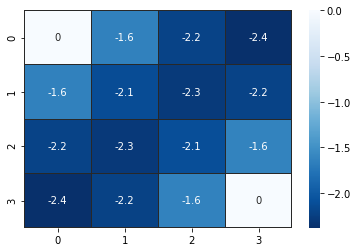

In [28]:
show_values(V)

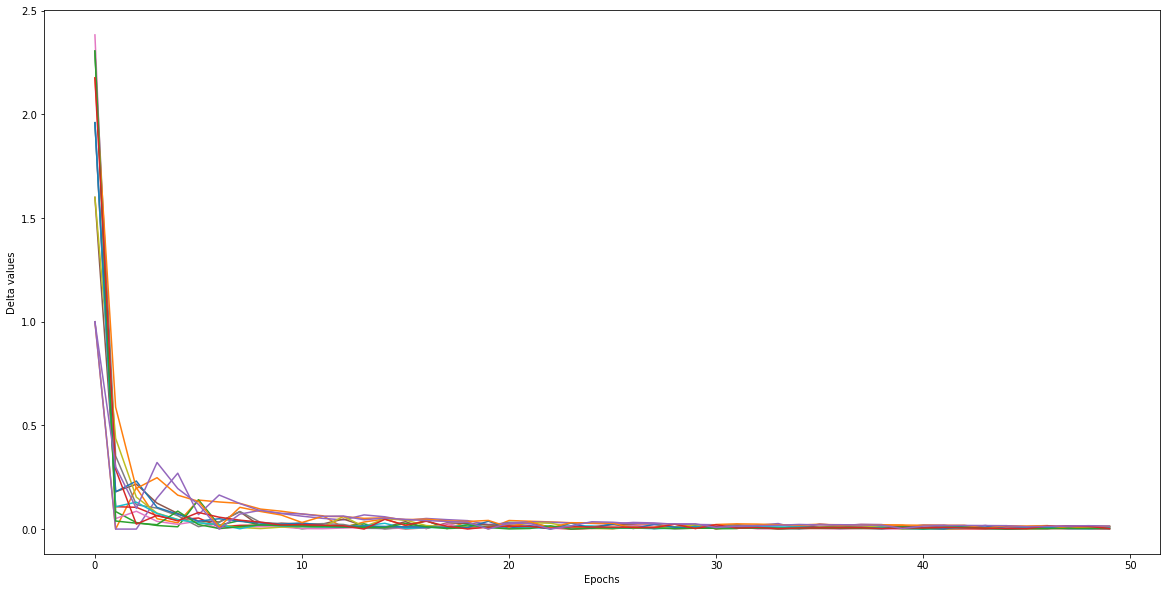

In [29]:
plt.figure(figsize=(20,10))
all_series = [list(x)[:50] for x in deltas.values()]
plt.xlabel("Epochs")
plt.ylabel("Delta values")
for series in all_series:
    plt.plot(series)
    